In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from functools import reduce
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss, ccf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Data Preprocessing

Набора от данни съдържа два .csv файла, които съдържат почасова информация за производството на електроенергия и времето в Испания за периода 2015-2019 (4 години). По-специално:

__"weather_features.csv"__: Съдържа почасова информация за метеорологичните условия (напр. температура, скорост на вятъра, влажност, валежи, качествено описание) на 5 големи града в Испания (Мадрид, Барселона, Валенсия, Севиля и Билбао).

__„energy_dataset.csv“__: Съдържа почасова информация за генерирането на енергия в Испания. По-специално, има информация (в MW) за количеството електроенергия, генерирана от различните енергийни източници (изкопаем газ, изкопаеми въглища и вятърна енергия доминират в енергийната мрежа), както и за общото натоварване (потребление на енергия) на националната мрежа и цената на енергията (€/MWh).

## Electricity Dataset

In [5]:
electricity_raw_data = pd.read_table("raw_data\energy_dataset.csv", sep=',')
electricity_raw_data[:3]

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48


In [6]:
electricity_raw_data.dtypes

time                                            object
generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil coal-derived gas             float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation fossil oil shale                    float64
generation fossil peat                         float64
generation geothermal                          float64
generation hydro pumped storage aggregated     float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation marine                              float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation

In [7]:
electricity_raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation fossil coal-derived gas,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation fossil oil shale,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation fossil peat,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation geothermal,35046.0,0.000000,0.000000,0.00,0.0000,0.00,0.00,0.00
generation hydro pumped storage aggregated,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# set 'time' column as index
electricity_raw_data['time'] = pd.to_datetime(electricity_raw_data['time'], utc=True, infer_datetime_format=True)
electricity_raw_data = electricity_raw_data.set_index('time')

In [9]:
electricity_raw_data[:3]

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,...,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,...,196.0,0.0,6378.0,17.0,NaN,6436.0,26118.0,25385.0,50.10,65.41
2015-01-01 00:00:00+00:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,...,195.0,0.0,5890.0,16.0,NaN,5856.0,24934.0,24382.0,48.10,64.92
2015-01-01 01:00:00+00:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,...,196.0,0.0,5461.0,8.0,NaN,5454.0,23515.0,22734.0,47.33,64.48


In [11]:
electricity_raw_data.loc[pd.isnull(electricity_raw_data["generation fossil oil"])].shape

(19, 28)

In [27]:
electricity_raw_data.loc[pd.isnull(electricity_raw_data["generation biomass"])].shape

(19, 28)

In [34]:
electricity_raw_data.loc[pd.isnull(electricity_raw_data["forecast wind offshore eday ahead"])].shape

(35064, 28)

In [43]:
# Delete columns without data (only zerros) or with nans

names = list(electricity_raw_data.columns)
no_data_col = []
for name in names:
    if electricity_raw_data[name].max()==0:
        no_data_col.append(name)       
no_data_col = no_data_col + electricity_raw_data.columns[electricity_raw_data.isna().all()].tolist()
print(no_data_col)
        

['generation fossil coal-derived gas', 'generation fossil oil shale', 'generation fossil peat', 'generation geothermal', 'generation marine', 'generation wind offshore', 'generation hydro pumped storage aggregated', 'forecast wind offshore eday ahead']


In [44]:
electricity = electricity_raw_data.drop(no_data_col, axis=1)
electricity.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
generation biomass,35045.0,383.513540,85.353943,0.00,333.0000,367.00,433.00,592.00
generation fossil brown coal/lignite,35046.0,448.059208,354.568590,0.00,0.0000,509.00,757.00,999.00
generation fossil gas,35046.0,5622.737488,2201.830478,0.00,4126.0000,4969.00,6429.00,20034.00
generation fossil hard coal,35046.0,4256.065742,1961.601013,0.00,2527.0000,4474.00,5838.75,8359.00
generation fossil oil,35045.0,298.319789,52.520673,0.00,263.0000,300.00,330.00,449.00
generation hydro pumped storage consumption,35045.0,475.577343,792.406614,0.00,0.0000,68.00,616.00,4523.00
generation hydro run-of-river and poundage,35045.0,972.116108,400.777536,0.00,637.0000,906.00,1250.00,2000.00
generation hydro water reservoir,35046.0,2605.114735,1835.199745,0.00,1077.2500,2164.00,3757.00,9728.00
generation nuclear,35047.0,6263.907039,839.667958,0.00,5760.0000,6566.00,7025.00,7117.00
generation other,35046.0,60.228585,20.238381,0.00,53.0000,57.00,80.00,106.00


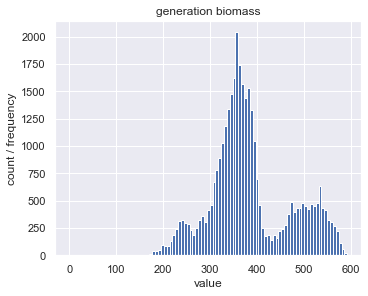

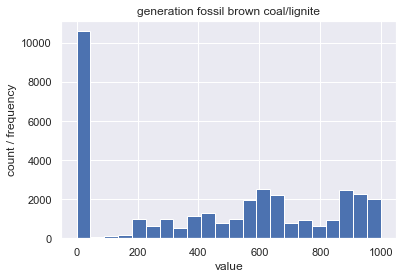

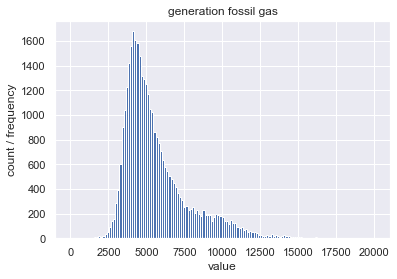

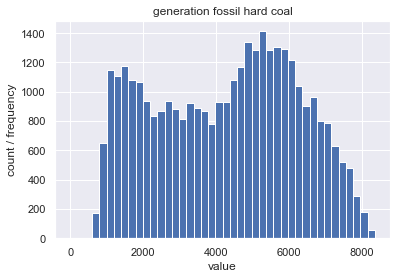

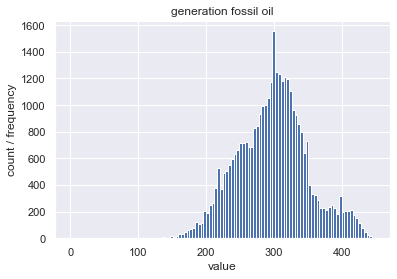

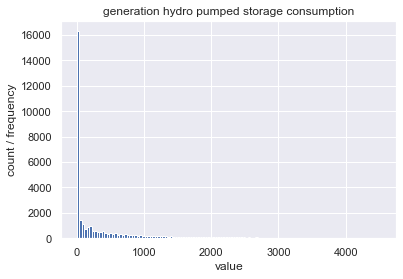

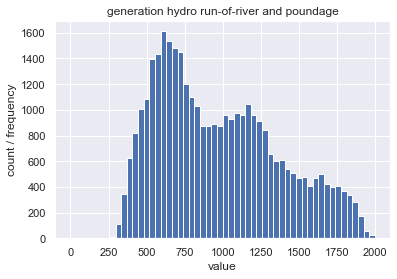

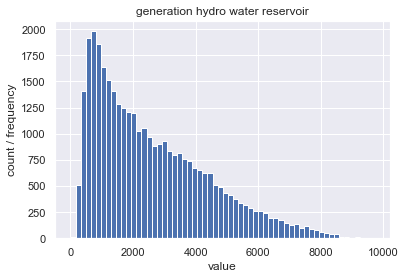

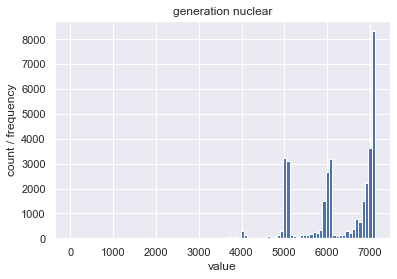

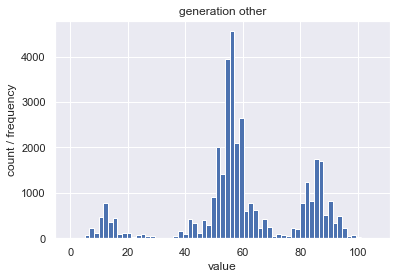

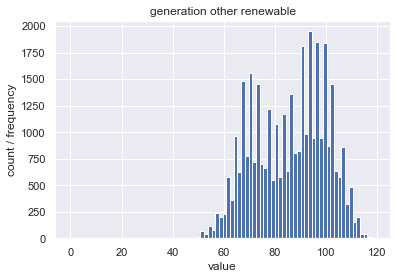

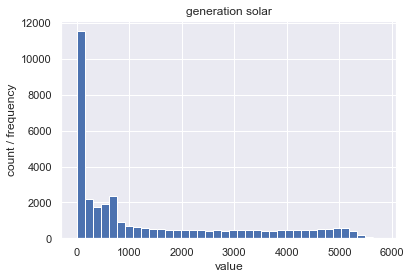

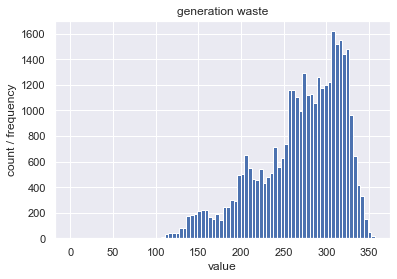

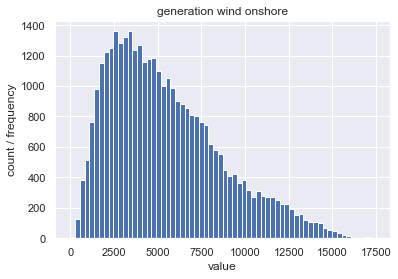

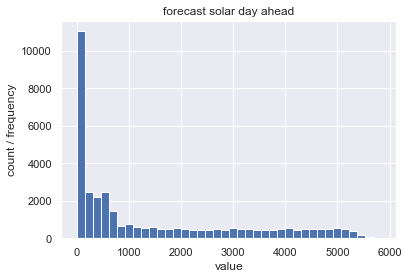

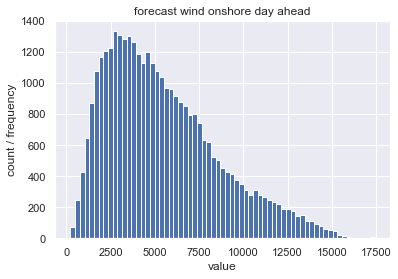

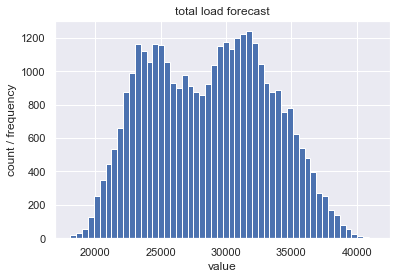

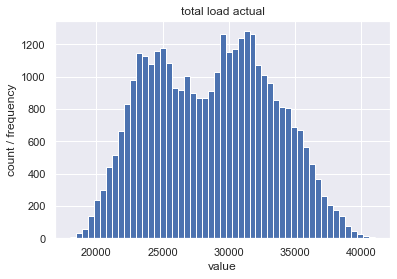

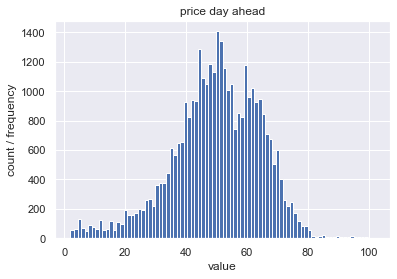

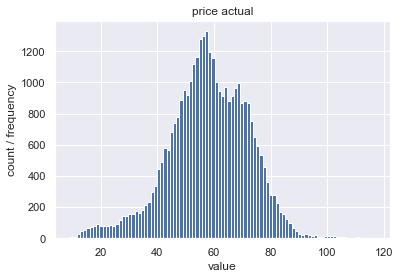

In [112]:
names = list(electricity.columns)
fig = plt.subplots(figsize=(5,4), constrained_layout=True)
for name in names:    
    plt.hist(electricity_raw_data[name], bins = 'fd')
    plt.ylabel("count / frequency")
    plt.xlabel("value")
    plt.title(name)
    plt.show()

In [113]:
electricity.loc[pd.isnull(electricity["total load actual"])].count()

generation biomass                             23
generation fossil brown coal/lignite           23
generation fossil gas                          23
generation fossil hard coal                    23
generation fossil oil                          23
generation hydro pumped storage consumption    23
generation hydro run-of-river and poundage     23
generation hydro water reservoir               23
generation nuclear                             24
generation other                               23
generation other renewable                     23
generation solar                               23
generation waste                               23
generation wind onshore                        23
forecast solar day ahead                       36
forecast wind onshore day ahead                36
total load forecast                            36
total load actual                               0
price day ahead                                36
price actual                                   36


In [114]:
electricity.isnull().sum(axis=0)

generation biomass                             19
generation fossil brown coal/lignite           18
generation fossil gas                          18
generation fossil hard coal                    18
generation fossil oil                          19
generation hydro pumped storage consumption    19
generation hydro run-of-river and poundage     19
generation hydro water reservoir               18
generation nuclear                             17
generation other                               18
generation other renewable                     18
generation solar                               18
generation waste                               19
generation wind onshore                        18
forecast solar day ahead                        0
forecast wind onshore day ahead                 0
total load forecast                             0
total load actual                              36
price day ahead                                 0
price actual                                    0


In [120]:
# max miss value in "total load actual" --- 36 
electricity.loc[pd.isnull(electricity["total load actual"])].head(10)

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind onshore,forecast solar day ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
time,,,,,,,,,,,,,,,,,,,,
2015-01-05 11:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3932.0,9258.0,23209.0,NaN,35.50,79.14
2015-01-05 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4236.0,9156.0,23725.0,NaN,36.80,73.95
2015-01-05 13:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4215.0,9072.0,23614.0,NaN,32.50,71.93
2015-01-05 14:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4050.0,8779.0,22381.0,NaN,30.00,71.50
2015-01-05 15:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3728.0,8426.0,21371.0,NaN,30.00,71.85
2015-01-05 16:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3175.0,7946.0,20760.0,NaN,30.60,80.53
2015-01-28 12:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4136.0,6223.0,36239.0,NaN,65.00,77.62
2015-02-01 06:00:00+00:00,449.0,312.0,4765.0,5269.0,222.0,480.0,980.0,1174.0,7101.0,44.0,75.0,48.0,208.0,3289.0,18.0,3141.0,24379.0,NaN,56.10,16.98
2015-02-01 07:00:00+00:00,453.0,312.0,4938.0,5652.0,288.0,0.0,1031.0,3229.0,7099.0,44.0,75.0,73.0,207.0,3102.0,63.0,3165.0,27389.0,NaN,57.69,19.56


In [118]:
def plot_series(df=None, column=None, series=pd.Series([]), 
                label=None, ylabel=None, title=None, start=0, end=None):
    """
    Plots a certain time-series which has either been loaded in a dataframe
    and which constitutes one of its columns or it a custom pandas series 
    created by the user. The user can define either the 'df' and the 'column' 
    or the 'series' and additionally, can also define the 'label', the 
    'ylabel', the 'title', the 'start' and the 'end' of the plot.
    """
    sns.set()
    fig, ax = plt.subplots(figsize=(30, 12))
    ax.set_xlabel('Time', fontsize=16)
    if column:
        ax.plot(df[column][start:end], label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if series.any():
        ax.plot(series, label=label)
        ax.set_ylabel(ylabel, fontsize=16)
    if label:
        ax.legend(fontsize=16)
    if title:
        ax.set_title(title, fontsize=24)
    ax.grid(True)
    return ax

<ipython-input-118-8dd8e79e1662>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  def plot_series(df=None, column=None, series=pd.Series([]),


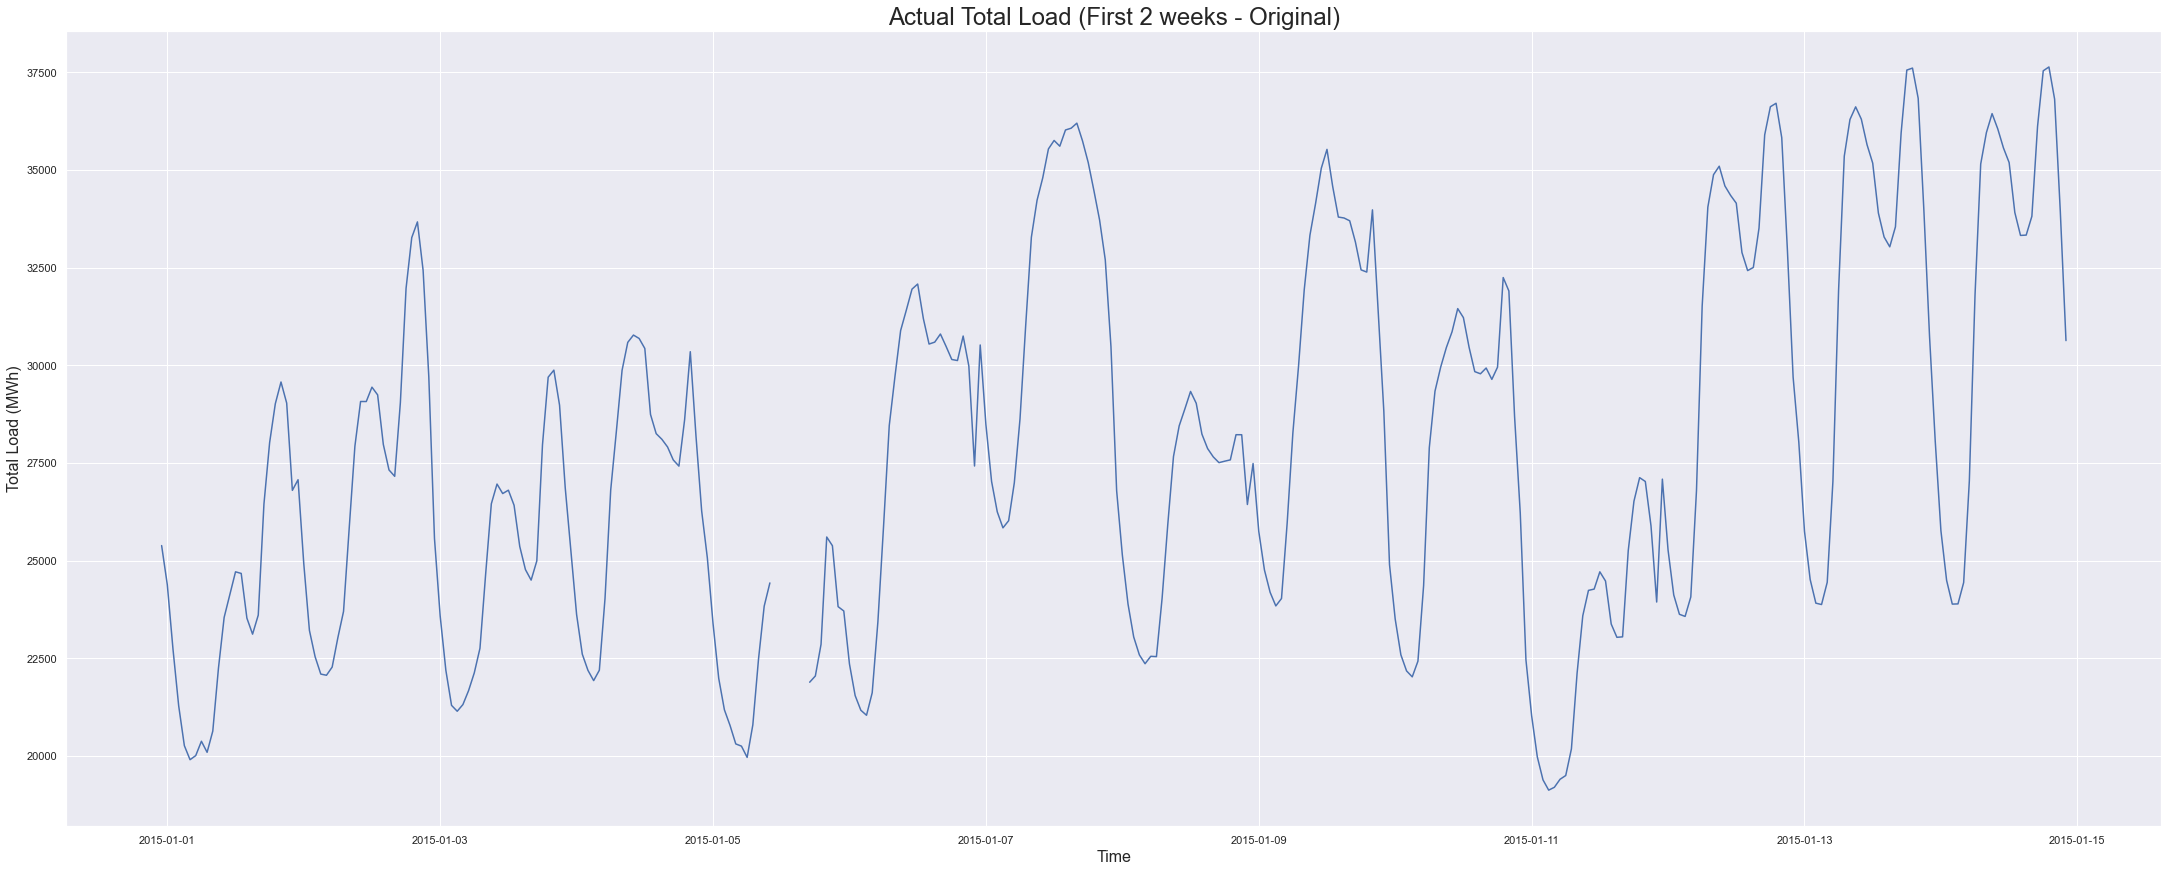

In [117]:
ax = plot_series(df=electricity, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Original)', end=24*7*2)
plt.show()

In [124]:
# Fill empty data with linear method
energy_df = electricity.interpolate(method='linear', limit_direction='forward', axis=0)

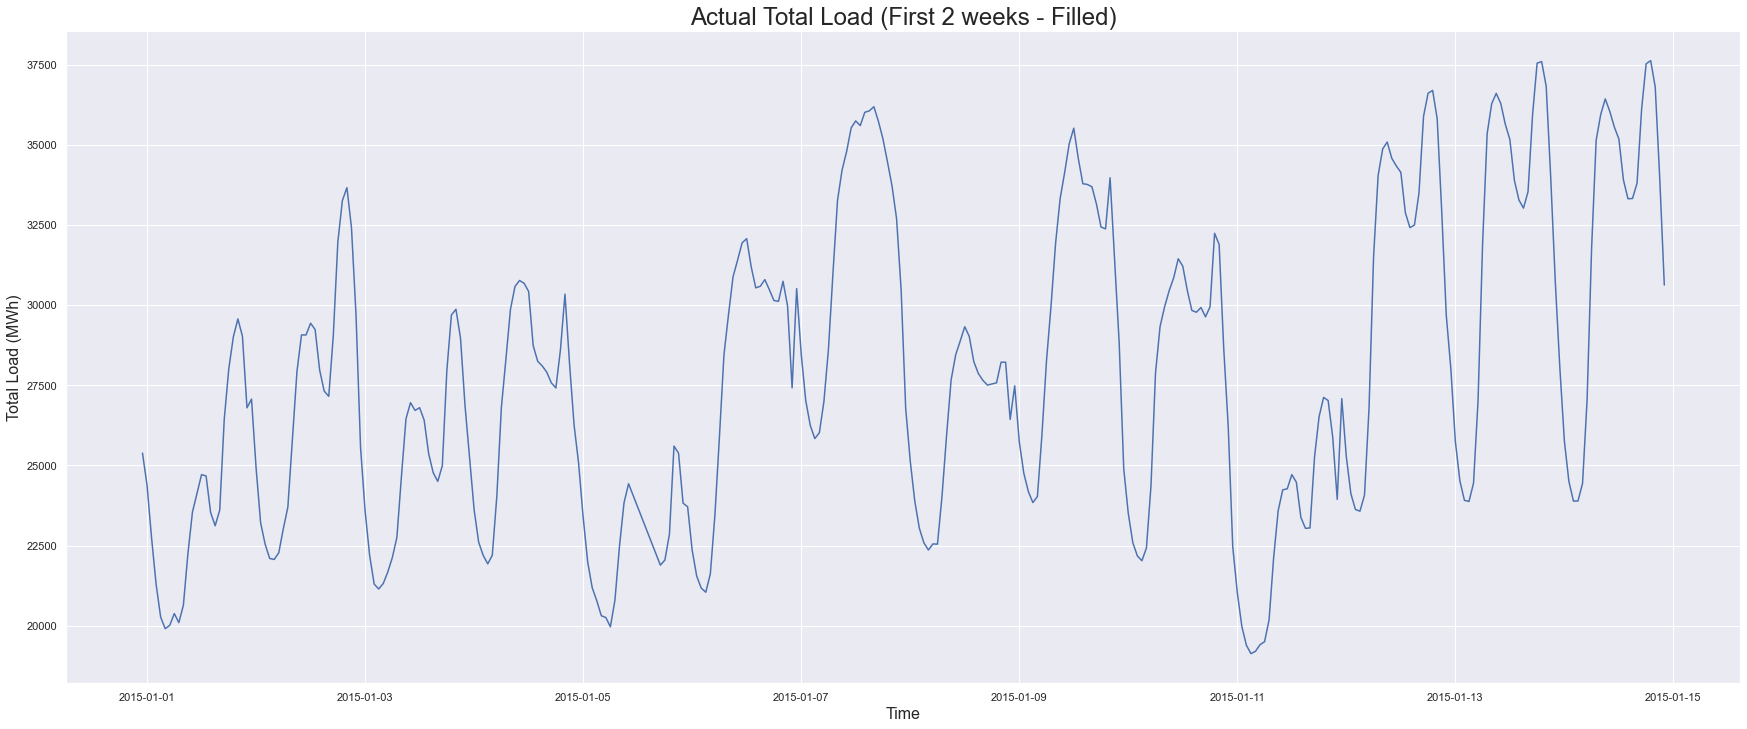

In [126]:
ax = plot_series(df=energy_df, column='total load actual', ylabel='Total Load (MWh)',
                 title='Actual Total Load (First 2 weeks - Filled)', end=24*7*2)
plt.show()

In [127]:
energy_df.dtypes

generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation solar                               float64
generation waste                               float64
generation wind onshore                        float64
forecast solar day ahead                       float64
forecast wind onshore day ahead                float64
total load forecast                            float64
total load actual                              float64
price day 

In [128]:
energy_df.shape

(35064, 20)

In [ ]:
# NB!!! ----> total load forecast and price day ahead  - да ги махна като моделирам

## Weather Dataset

In [155]:
weather_raw_data = pd.read_table("raw_data\weather_features.csv", sep=',')
weather_raw_data[:3]

,dt_iso,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
0,2015-01-01 00:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
1,2015-01-01 01:00:00+01:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2,2015-01-01 02:00:00+01:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [156]:
weather_raw_data.shape

(178396, 17)

In [157]:
weather_raw_data.dtypes

dt_iso                  object
city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure                 int64
humidity                 int64
wind_speed               int64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [158]:
weather_raw_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
temp,178396.0,289.618605,8.026199,262.24,283.670000,289.15,295.150000,315.600
temp_min,178396.0,288.330442,7.955491,262.24,282.483602,288.15,293.730125,315.150
temp_max,178396.0,291.091267,8.612454,262.24,284.650000,290.15,297.150000,321.150
pressure,178396.0,1069.260740,5969.631893,0.00,1013.000000,1018.00,1022.000000,1008371.000
humidity,178396.0,68.423457,21.902888,0.00,53.000000,72.00,87.000000,100.000
wind_speed,178396.0,2.470560,2.095910,0.00,1.000000,2.00,4.000000,133.000
wind_deg,178396.0,166.591190,116.611927,0.00,55.000000,177.00,270.000000,360.000
rain_1h,178396.0,0.075492,0.398847,0.00,0.000000,0.00,0.000000,12.000
rain_3h,178396.0,0.000380,0.007288,0.00,0.000000,0.00,0.000000,2.315
snow_3h,178396.0,0.004763,0.222604,0.00,0.000000,0.00,0.000000,21.500


In [159]:
weather_raw_data.city_name.unique()

array(['Valencia', 'Madrid', 'Bilbao', ' Barcelona', 'Seville'],
      dtype=object)

In [160]:
#set weather_raw_data['time'] as index
weather_raw_data['time'] = pd.to_datetime(weather_raw_data['dt_iso'], utc=True, infer_datetime_format=True)
weather_raw_data = weather_raw_data.drop(['dt_iso'], axis=1)
weather_raw_data = weather_raw_data.set_index('time')

In [161]:
weather_raw_data.head()

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
time,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [162]:
#  Find NaNs and duplicates in weather_raw_data in index rows

print('There are {} missing values or NaNs in weather_raw_data.'
      .format(weather_raw_data.isnull().values.sum()))

temp_weather = weather_raw_data.duplicated(keep='first').sum()

print('There are {} duplicate rows in weather_raw_data based on all columns.'
      .format(temp_weather))

There are 0 missing values or NaNs in weather_raw_data.
There are 8622 duplicate rows in weather_raw_data based on all columns.


In [ ]:
# weather_raw_data има дублиращи се стойности . 
# Въпреки това, методът по-горе може също да ни покаже редове, които имат едни и същи стойности. 
# Това, което искаме да гарантираме е, че няма дублиращи се индексни редове, т.е. че нямаме множество редове за същия час. 
# Също трябва да се уверим, че тези дубликати се отнасят за всеки отделен град . 
# weather_raw_data съдържа информация за 5 различни града и искаме да покажем броят на наблюденията 
# за всеки един град и да се сравним с размера на df_energy.


In [163]:
# weather_raw_data_2 = weather_raw_data.reset_index().drop_duplicates(subset=['time', 'city_name'], 
#                                                         keep='last').set_index('time')
# weather_raw_data = weather_raw_data.reset_index().drop_duplicates(subset=['time', 'city_name'],
#                                                       keep='first').set_index('time')
weather_raw_data = weather_raw_data.reset_index().drop_duplicates(subset=['time', 'city_name'],
                                                      keep='last').set_index('time')

In [164]:
weather_raw_data

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main,weather_description,weather_icon
time,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 00:00:00+00:00,Valencia,270.475,270.475,270.475,1001,77,1,62,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 01:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 02:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2015-01-01 03:00:00+00:00,Valencia,269.686,269.686,269.686,1002,78,0,23,0.0,0.0,0.0,0,800,clear,sky is clear,01n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,Seville,287.760,287.150,288.150,1028,54,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-12-31 19:00:00+00:00,Seville,285.760,285.150,286.150,1029,62,3,30,0.0,0.0,0.0,0,800,clear,sky is clear,01n
2018-12-31 20:00:00+00:00,Seville,285.150,285.150,285.150,1028,58,4,50,0.0,0.0,0.0,0,800,clear,sky is clear,01n


In [165]:
#Уверяваме се, че броя наблюдения в energy_df и във всеки град от weather_raw_data съвпадат за да можем по-късно 
# да преорганизираме сета
print('{} obsr in df_energy.'.format(energy_df.shape[0]))

grouped_weather = weather_raw_data.groupby('city_name')

for city in weather_raw_data.city_name.unique():
    print('{} obsr in weather_raw_data'
          .format(grouped_weather.get_group('{}'.format(city)).shape[0]), 
          'about city: {}.'.format(city))

35064 obsr in df_energy.
35064 obsr in weather_raw_data about city: Valencia.
35064 obsr in weather_raw_data about city: Madrid.
35064 obsr in weather_raw_data about city: Bilbao.
35064 obsr in weather_raw_data about city:  Barcelona.
35064 obsr in weather_raw_data about city: Seville.


In [166]:
def df_convert_dtypes(df, convert_from, convert_to):
    cols = df.select_dtypes(include=[convert_from]).columns
    for col in cols:
        df[col] = df[col].values.astype(convert_to)
    return df

In [167]:
weather_raw_data = df_convert_dtypes(weather_raw_data, np.int64, np.float64)
weather_raw_data.dtypes

city_name               object
temp                   float64
temp_min               float64
temp_max               float64
pressure               float64
humidity               float64
wind_speed             float64
wind_deg               float64
rain_1h                float64
rain_3h                float64
snow_3h                float64
clouds_all             float64
weather_id             float64
weather_main            object
weather_description     object
weather_icon            object
dtype: object

In [168]:
mean_weather_by_city = weather_raw_data.groupby('city_name').mean()
mean_weather_by_city

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id
city_name,,,,,,,,,,,,
Barcelona,289.867178,288.615102,291.039356,1287.211356,73.830710,2.782740,187.664243,0.108487,0.000331,0.000000,22.714693,764.373346
Bilbao,286.443451,284.989988,288.090330,1017.483858,78.731006,1.958305,159.908938,0.119156,0.001057,0.024048,43.438712,728.153377
Madrid,288.277131,287.051835,289.371963,1011.781115,58.725331,2.433807,173.363906,0.043301,0.000133,0.000030,20.661334,770.170431
Seville,293.166541,291.259597,296.001726,1018.536990,63.780516,2.482717,151.885809,0.041136,0.000182,0.000000,14.165070,774.518338
Valencia,290.783954,290.225644,291.357900,1015.979381,65.093971,2.692477,160.801648,0.034458,0.000227,0.000154,20.740475,781.978297


In [169]:
mean_weather_by_city.index

Index([' Barcelona', 'Bilbao', 'Madrid', 'Seville', 'Valencia'], dtype='object', name='city_name')

In [170]:
len(weather_raw_data['weather_description'].unique()),len(weather_raw_data['weather_main'].unique()), len(weather_raw_data['weather_id'].unique())


(43, 12, 38)

In [171]:
# 'weather_description', 'weather_icon' - ще ползваме weather_main защото информацията се преповтаря
weather_raw_data = weather_raw_data.drop(['weather_description', 'weather_icon'], axis=1)

In [172]:
len(weather_raw_data['weather_main'].unique()), len(weather_raw_data['weather_id'].unique())

(12, 38)

In [ ]:
# Ще потърсим и изчистим необичайните стойности в данните

In [173]:
# Приемаме, че стойности на атмосферното налягане извън диапазона 910-2000 са невъзможни и ги заменя с null. 
# По късно ще интерполираме тези "nan" ползвайки подходящ метод.
weather_raw_data.loc[weather_raw_data.pressure > 2000, 'pressure']=np.nan

In [174]:
weather_raw_data.loc[weather_raw_data.pressure < 910, 'pressure']=np.nan

In [175]:
weather_raw_data.loc[weather_raw_data.wind_deg ==0, 'wind_deg'].count(), weather_raw_data.loc[weather_raw_data.wind_deg ==360, 'wind_deg'].count()

(24350, 2566)

In [176]:
weather_raw_data.loc[weather_raw_data.rain_3h < weather_raw_data.rain_1h, 'rain_3h'].count()

17392

In [178]:
weather_1h = weather_raw_data.loc[(weather_raw_data['rain_1h'] > weather_raw_data['rain_3h']) ]
weather_1h

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main
time,,,,,,,,,,,,,,
2015-01-07 01:00:00+00:00,Valencia,279.626000,279.626000,279.626000,998.0,99.0,1.0,314.0,0.3,0.0,0.0,88.0,500.0,rain
2015-01-07 02:00:00+00:00,Valencia,279.626000,279.626000,279.626000,998.0,99.0,1.0,314.0,0.3,0.0,0.0,88.0,500.0,rain
2015-01-07 03:00:00+00:00,Valencia,279.626000,279.626000,279.626000,998.0,99.0,1.0,314.0,0.3,0.0,0.0,88.0,500.0,rain
2015-01-07 07:00:00+00:00,Valencia,278.031687,278.031687,278.031687,1029.0,90.0,1.0,344.0,0.3,0.0,0.0,68.0,500.0,rain
2015-01-07 08:00:00+00:00,Valencia,278.773344,278.773344,278.773344,1030.0,86.0,2.0,342.0,0.3,0.0,0.0,80.0,500.0,rain
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-19 03:00:00+00:00,Seville,287.150000,287.150000,287.150000,1023.0,93.0,2.0,190.0,0.3,0.0,0.0,40.0,500.0,rain
2018-12-19 04:00:00+00:00,Seville,287.520000,287.150000,288.150000,1023.0,93.0,4.0,230.0,0.9,0.0,0.0,40.0,501.0,rain
2018-12-19 05:00:00+00:00,Seville,287.540000,287.150000,288.150000,1023.0,93.0,3.0,230.0,0.3,0.0,0.0,75.0,500.0,rain


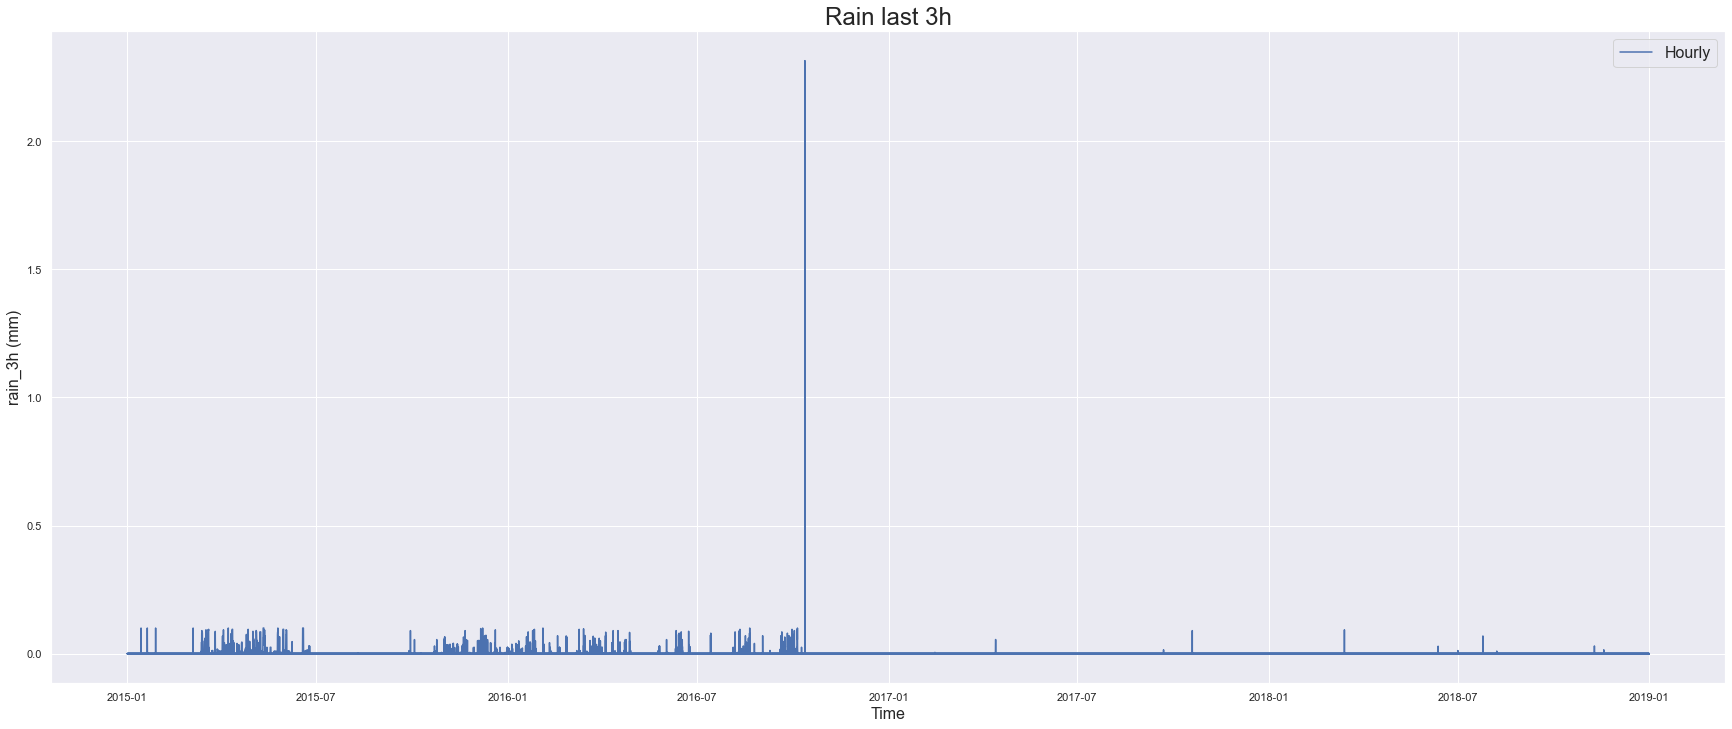

In [180]:
ax = plot_series(weather_raw_data, 'rain_3h', 
                 label='Hourly', ylabel='rain_3h (mm)',
                 title='Rain last 3h')
plt.show()

In [182]:
weather_raw_data.loc[(weather_raw_data['rain_3h'] >2) ]
# https://www.nwcsaf.org/spain-20161012-solution
# On this day, there were very intense precipitations near Barcelona in a location named Cabrils. A total of 220 mm were registered here. 
# Almost all of the precipitation fell in an afternoon, starting at approximately 15Z.

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main
time,,,,,,,,,,,,,,
2016-10-12 10:00:00+00:00,Bilbao,288.182,288.182,288.182,976.0,76.0,1.0,159.0,0.0,2.315,0.0,64.0,803.0,clouds


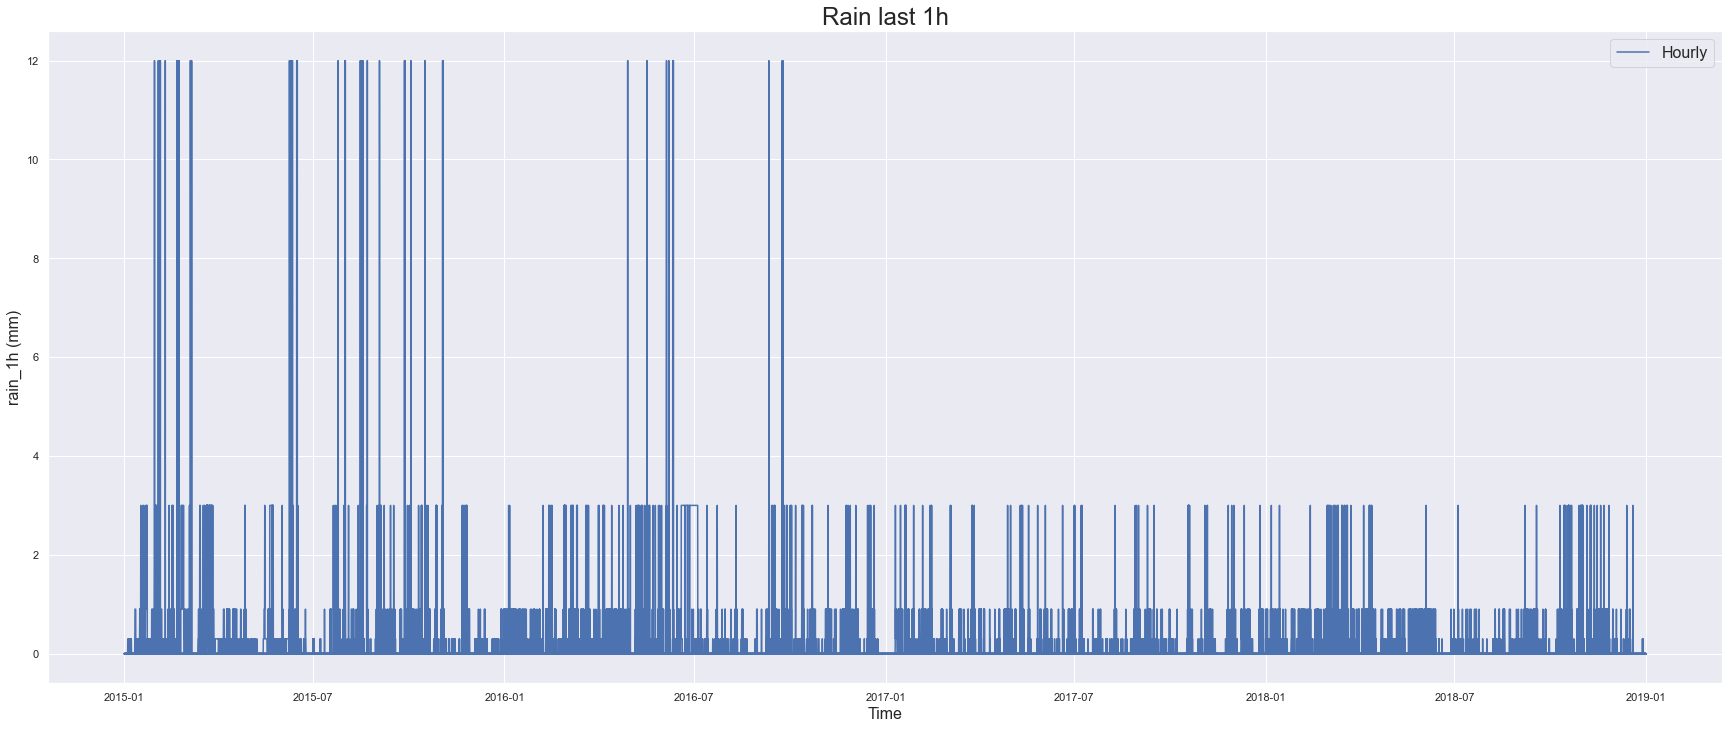

In [183]:
ax = plot_series(weather_raw_data, 'rain_1h', 
                 label='Hourly', ylabel='rain_1h (mm)',
                 title='Rain last 1h')
plt.show()

In [184]:
weather_raw_data.loc[(weather_raw_data['rain_1h'] >10) ].city_name.unique()

array(['Valencia', ' Barcelona'], dtype=object)

In [186]:
weather_raw_data.loc[weather_raw_data.wind_speed > 90, ['wind_speed', "city_name"] ]
# https://weatherspark.com/h/m/147844/2017/5/Historical-Weather-in-May-2017-at-Valencia-Airport-Spain#Figures-WindSpeed
# 11:30 AM 	68°F 	29.59 inHg 	299 mph, N 	6.21 mi 	Mostly Clear (2,500 ft) 
# 299 mph ----->  133.66496 m / s

,wind_speed,city_name
time,,
2017-05-11 10:00:00+00:00,133.0,Valencia


In [187]:
weather_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   city_name     175320 non-null  object 
 1   temp          175320 non-null  float64
 2   temp_min      175320 non-null  float64
 3   temp_max      175320 non-null  float64
 4   pressure      175272 non-null  float64
 5   humidity      175320 non-null  float64
 6   wind_speed    175320 non-null  float64
 7   wind_deg      175320 non-null  float64
 8   rain_1h       175320 non-null  float64
 9   rain_3h       175320 non-null  float64
 10  snow_3h       175320 non-null  float64
 11  clouds_all    175320 non-null  float64
 12  weather_id    175320 non-null  float64
 13  weather_main  175320 non-null  object 
dtypes: float64(12), object(2)
memory usage: 20.1+ MB


In [195]:
weather_raw_data.isnull().sum(axis=0)

city_name        0
temp             0
temp_min         0
temp_max         0
pressure        48
humidity         0
wind_speed       0
wind_deg         0
rain_1h          0
rain_3h          0
snow_3h          0
clouds_all       0
weather_id       0
weather_main     0
dtype: int64

In [193]:
weather_raw_data.loc[pd.isnull(weather_raw_data["pressure"])]

,city_name,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,rain_3h,snow_3h,clouds_all,weather_id,weather_main
time,,,,,,,,,,,,,,
2015-02-20 08:00:00+00:00,Barcelona,284.360000,284.360000,284.360000,NaN,0.0,1.0,275.0,0.0,0.0,0.0,0.0,800.0,clear
2015-02-20 09:00:00+00:00,Barcelona,286.360000,286.360000,286.360000,NaN,0.0,1.0,275.0,0.0,0.0,0.0,0.0,800.0,clear
2015-02-20 10:00:00+00:00,Barcelona,286.050000,286.050000,286.050000,NaN,0.0,2.0,67.0,12.0,0.0,0.0,0.0,503.0,rain
2015-02-20 11:00:00+00:00,Barcelona,286.050000,286.050000,286.050000,NaN,0.0,2.0,219.0,0.0,0.0,0.0,0.0,800.0,clear
2015-02-20 12:00:00+00:00,Barcelona,286.960000,286.960000,286.960000,NaN,0.0,1.0,67.0,0.0,0.0,0.0,0.0,800.0,clear
2015-02-20 13:00:00+00:00,Barcelona,277.050000,277.050000,277.050000,NaN,0.0,1.0,67.0,0.0,0.0,0.0,0.0,800.0,clear
2015-02-20 14:00:00+00:00,Barcelona,286.750000,286.750000,286.750000,NaN,0.0,1.0,292.0,0.0,0.0,0.0,0.0,800.0,clear
2015-02-20 15:00:00+00:00,Barcelona,286.850000,286.850000,286.850000,NaN,0.0,1.0,315.0,0.0,0.0,0.0,0.0,800.0,clear
2015-02-20 17:00:00+00:00,Barcelona,285.450000,285.450000,285.450000,NaN,0.0,1.0,67.0,0.0,0.0,0.0,8.0,800.0,clear


In [196]:
weather_raw_data.interpolate(method='linear', limit_direction='forward', inplace=True, axis=0)

In [197]:
weather_raw_data.isnull().sum(axis=0)

city_name       0
temp            0
temp_min        0
temp_max        0
pressure        0
humidity        0
wind_speed      0
wind_deg        0
rain_1h         0
rain_3h         0
snow_3h         0
clouds_all      0
weather_id      0
weather_main    0
dtype: int64

In [198]:
weather_raw_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 175320 entries, 2014-12-31 23:00:00+00:00 to 2018-12-31 22:00:00+00:00
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   city_name     175320 non-null  object 
 1   temp          175320 non-null  float64
 2   temp_min      175320 non-null  float64
 3   temp_max      175320 non-null  float64
 4   pressure      175320 non-null  float64
 5   humidity      175320 non-null  float64
 6   wind_speed    175320 non-null  float64
 7   wind_deg      175320 non-null  float64
 8   rain_1h       175320 non-null  float64
 9   rain_3h       175320 non-null  float64
 10  snow_3h       175320 non-null  float64
 11  clouds_all    175320 non-null  float64
 12  weather_id    175320 non-null  float64
 13  weather_main  175320 non-null  object 
dtypes: float64(12), object(2)
memory usage: 20.1+ MB


In [199]:
weather_raw_data["weather_main"].unique()

array(['clear', 'clouds', 'rain', 'mist', 'thunderstorm', 'drizzle',
       'fog', 'smoke', 'haze', 'snow', 'dust', 'squall'], dtype=object)

In [200]:
# weather_id ----> object остава само weather_main
# rain_3h ------> bad data
weather_raw_data = weather_raw_data.drop(['rain_3h', 'weather_id'], axis=1)

In [201]:
# Обработваме категорийните променливи
weather_df_dummies = pd.get_dummies(weather_raw_data)
weather_df_dummies

,temp,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,rain_1h,snow_3h,clouds_all,...,weather_main_drizzle,weather_main_dust,weather_main_fog,weather_main_haze,weather_main_mist,weather_main_rain,weather_main_smoke,weather_main_snow,weather_main_squall,weather_main_thunderstorm
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 00:00:00+00:00,270.475,270.475,270.475,1001.0,77.0,1.0,62.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00+00:00,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00+00:00,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,269.686,269.686,269.686,1002.0,78.0,0.0,23.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,287.760,287.150,288.150,1028.0,54.0,3.0,30.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 19:00:00+00:00,285.760,285.150,286.150,1029.0,62.0,3.0,30.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 20:00:00+00:00,285.150,285.150,285.150,1028.0,58.0,4.0,50.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [202]:
weather_df_dummies.dtypes

temp                         float64
temp_min                     float64
temp_max                     float64
pressure                     float64
humidity                     float64
wind_speed                   float64
wind_deg                     float64
rain_1h                      float64
snow_3h                      float64
clouds_all                   float64
city_name_ Barcelona           uint8
city_name_Bilbao               uint8
city_name_Madrid               uint8
city_name_Seville              uint8
city_name_Valencia             uint8
weather_main_clear             uint8
weather_main_clouds            uint8
weather_main_drizzle           uint8
weather_main_dust              uint8
weather_main_fog               uint8
weather_main_haze              uint8
weather_main_mist              uint8
weather_main_rain              uint8
weather_main_smoke             uint8
weather_main_snow              uint8
weather_main_squall            uint8
weather_main_thunderstorm      uint8
d

# Combined Dataset

In [ ]:
# Ще разделим weather_df на пет части - за петте града.
# Ще свържем двата сета като ползваме индексната колона за връзка.
# Да оправя шпацията пред  Barcelona

In [204]:
weather_df_dummies.dtypes

temp                         float64
temp_min                     float64
temp_max                     float64
pressure                     float64
humidity                     float64
wind_speed                   float64
wind_deg                     float64
rain_1h                      float64
snow_3h                      float64
clouds_all                   float64
city_name_ Barcelona           uint8
city_name_Bilbao               uint8
city_name_Madrid               uint8
city_name_Seville              uint8
city_name_Valencia             uint8
weather_main_clear             uint8
weather_main_clouds            uint8
weather_main_drizzle           uint8
weather_main_dust              uint8
weather_main_fog               uint8
weather_main_haze              uint8
weather_main_mist              uint8
weather_main_rain              uint8
weather_main_smoke             uint8
weather_main_snow              uint8
weather_main_squall            uint8
weather_main_thunderstorm      uint8
d

In [203]:
energy_df.dtypes

generation biomass                             float64
generation fossil brown coal/lignite           float64
generation fossil gas                          float64
generation fossil hard coal                    float64
generation fossil oil                          float64
generation hydro pumped storage consumption    float64
generation hydro run-of-river and poundage     float64
generation hydro water reservoir               float64
generation nuclear                             float64
generation other                               float64
generation other renewable                     float64
generation solar                               float64
generation waste                               float64
generation wind onshore                        float64
forecast solar day ahead                       float64
forecast wind onshore day ahead                float64
total load forecast                            float64
total load actual                              float64
price day 

In [205]:
def get_new_column_names(df, city):
    del_list = ['city_name_ Barcelona',
                 'city_name_Bilbao',
                 'city_name_Madrid',
                 'city_name_Seville',
                 'city_name_Valencia']
    df_new = df.drop(del_list, axis=1)
    
    old_names = df_new.columns 
    new_names = []
    
    for i in range(0, len(old_names)):
        colname = old_names[i]
        new_names.append(colname + f"_{city}")
    df_new.columns = new_names    
    return df_new

In [206]:
df_barcelona = get_new_column_names(weather_df_dummies[weather_df_dummies["city_name_ Barcelona"]==1], 'Barcelona')
df_bilbao = get_new_column_names(weather_df_dummies[weather_df_dummies["city_name_Bilbao"]==1], "Bilbao")
df_madrid = get_new_column_names(weather_df_dummies[weather_df_dummies["city_name_Madrid"]==1], "Madrid")
df_seville = get_new_column_names(weather_df_dummies[weather_df_dummies["city_name_Seville"]==1], "Seville")
df_valencia = get_new_column_names(weather_df_dummies[weather_df_dummies["city_name_Valencia"]==1], "Valencia")

In [207]:
df_prepared = reduce(lambda df1,df2: pd.merge(df1,df2,on=['time'], how='outer'), [energy_df, df_barcelona, df_bilbao, df_madrid, df_seville, df_valencia])
df_prepared

,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation nuclear,generation other,...,weather_main_drizzle_Valencia,weather_main_dust_Valencia,weather_main_fog_Valencia,weather_main_haze_Valencia,weather_main_mist_Valencia,weather_main_rain_Valencia,weather_main_smoke_Valencia,weather_main_snow_Valencia,weather_main_squall_Valencia,weather_main_thunderstorm_Valencia
time,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00+00:00,447.0,329.0,4844.0,4821.0,162.0,863.0,1051.0,1899.0,7096.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 00:00:00+00:00,449.0,328.0,5196.0,4755.0,158.0,920.0,1009.0,1658.0,7096.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 01:00:00+00:00,448.0,323.0,4857.0,4581.0,157.0,1164.0,973.0,1371.0,7099.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 02:00:00+00:00,438.0,254.0,4314.0,4131.0,160.0,1503.0,949.0,779.0,7098.0,43.0,...,0,0,0,0,0,0,0,0,0,0
2015-01-01 03:00:00+00:00,428.0,187.0,4130.0,3840.0,156.0,1826.0,953.0,720.0,7097.0,43.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 18:00:00+00:00,297.0,0.0,7634.0,2628.0,178.0,1.0,1135.0,4836.0,6073.0,63.0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 19:00:00+00:00,296.0,0.0,7241.0,2566.0,174.0,1.0,1172.0,3931.0,6074.0,62.0,...,0,0,0,0,0,0,0,0,0,0
2018-12-31 20:00:00+00:00,292.0,0.0,7025.0,2422.0,168.0,50.0,1148.0,2831.0,6076.0,61.0,...,0,0,0,0,0,0,0,0,0,0


In [208]:
list(df_prepared.columns)

['generation biomass',
 'generation fossil brown coal/lignite',
 'generation fossil gas',
 'generation fossil hard coal',
 'generation fossil oil',
 'generation hydro pumped storage consumption',
 'generation hydro run-of-river and poundage',
 'generation hydro water reservoir',
 'generation nuclear',
 'generation other',
 'generation other renewable',
 'generation solar',
 'generation waste',
 'generation wind onshore',
 'forecast solar day ahead',
 'forecast wind onshore day ahead',
 'total load forecast',
 'total load actual',
 'price day ahead',
 'price actual',
 'temp_Barcelona',
 'temp_min_Barcelona',
 'temp_max_Barcelona',
 'pressure_Barcelona',
 'humidity_Barcelona',
 'wind_speed_Barcelona',
 'wind_deg_Barcelona',
 'rain_1h_Barcelona',
 'snow_3h_Barcelona',
 'clouds_all_Barcelona',
 'weather_main_clear_Barcelona',
 'weather_main_clouds_Barcelona',
 'weather_main_drizzle_Barcelona',
 'weather_main_dust_Barcelona',
 'weather_main_fog_Barcelona',
 'weather_main_haze_Barcelona',
 '

In [209]:
print('There are {} missing values or NaNs in df_prepared.'
      .format(df_prepared.isnull().values.sum()))

temp_prepared = df_prepared.duplicated(keep='first').sum()

print('\nThere are {} duplicate rows in df_prepared based on all columns.'
      .format(temp_prepared))

There are 0 missing values or NaNs in df_prepared.

There are 0 duplicate rows in df_prepared based on all columns.


In [211]:
# Записваме обработените данни в нов сет.
df_prepared.to_csv('output_data_sets/combined_dataset.csv', index=True)